# Exploring the SVHN Data

### Importing neccessary libraries

In [122]:

from math import floor
from typing import List

import numpy as np
import scipy.io as sio

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


### Loading the test and training data

In [123]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [124]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

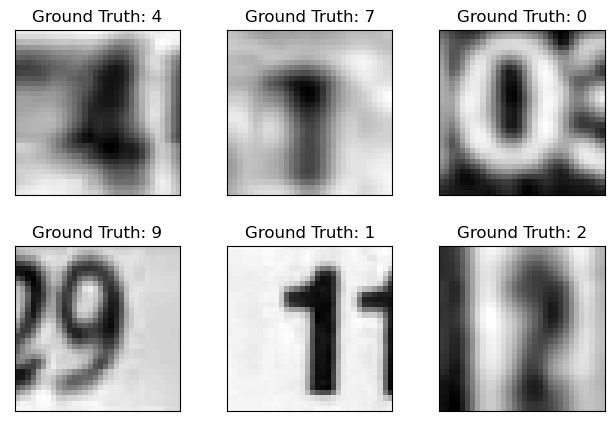

In [125]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [126]:
def layer_output_size(input : int, kernel, padding = 0, dilation = 1, stride = 1, max_pool = 1):
    return floor(((input + (2 * padding) - (dilation * (kernel - 1)) - 1) / stride + 1)/max_pool)

In [127]:
no_pool_size = layer_output_size(layer_output_size(32, 5), 5) ** 2 * 20
layer2_pool_size = layer_output_size(layer_output_size(32, 5), 5, max_pool=2) ** 2 * 20
layer1_pool_size = layer_output_size(layer_output_size(32, 5, max_pool=2), 5) ** 2 * 20
print(no_pool_size, layer2_pool_size, layer1_pool_size)


11520 2880 2000


In [145]:
class NoMaxPoolNet(nn.Module):
    def __init__(self):
        super(NoMaxPoolNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(11520, 1152)
        self.fc2 = nn.Linear(1152, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_drop(self.conv2(x)), 2)
        x = x.view(-1, 11520)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
class Layer1MaxPoolNet(nn.Module):
    def __init__(self):
        super(Layer1MaxPoolNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2000, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = x.view(-1, 2000)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

class Layer2MaxPoolNet(nn.Module):
    def __init__(self):
        super(Layer2MaxPoolNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2880, 288)
        self.fc2 = nn.Linear(288, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 2880)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [129]:
def train(network: nn.Module, optimizer, epoch: int, train_losses: List | None = None, train_counter: List | None = None):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if train_losses is not None and train_counter is not None:
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    #torch.save(network.state_dict(), '/results/model.pth')
    #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [130]:
def test(network: nn.Module, test_losses: List | None = None) -> float:
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  if test_losses is not None:
    test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return correct / len(test_loader.dataset)

### No pooling

In [131]:
network_no_pool = NoMaxPoolNet()
zero_pad_optimizer = optim.SGD(network_no_pool.parameters(), lr=learning_rate,
                      momentum=momentum)

In [132]:
train_losses_no_pool = []
train_counter_no_pool = []
test_losses_no_pool = []
test_counter_no_pool = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [133]:
print(example_data.shape)
test(network_no_pool, test_losses_no_pool)
for epoch in range(1, n_epochs + 1):
  train(network_no_pool, zero_pad_optimizer, 
        epoch, train_losses_no_pool, train_counter_no_pool)
  test(network_no_pool, test_losses_no_pool)

torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\439911123.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3050, Accuracy: 1831/26032 (7%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.304794
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.293486
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.292625
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.266106
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.244478
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.234116
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.275041
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.298993
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.198938
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.221840
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.240776
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.209733
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.257675
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.272548
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.286592
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.209800
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.187217
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.202328
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.153617
Train Epoch: 1 [12160/73

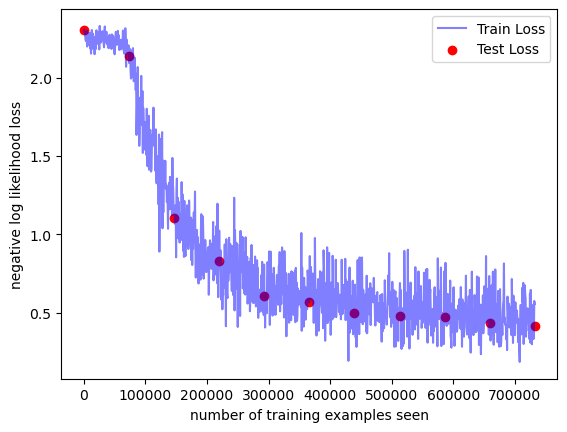

In [134]:
fig = plt.figure()
plt.plot(train_counter_no_pool, train_losses_no_pool, color='blue', alpha=.5)
plt.scatter(test_counter_no_pool, test_losses_no_pool, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [135]:
with torch.no_grad():
  output_no_pool = network_no_pool(example_data)

C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\439911123.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


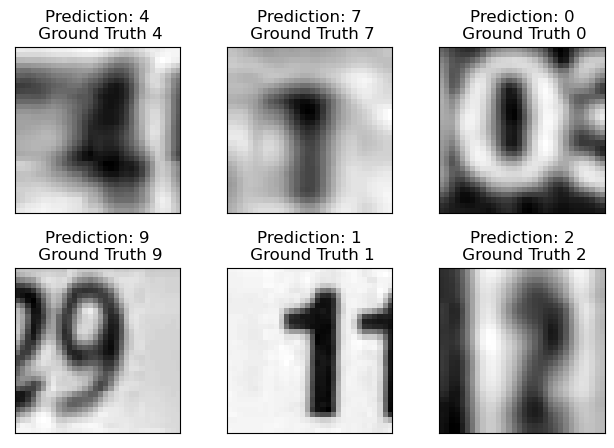

In [136]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  pred = output_no_pool.data.max(1, keepdim=True)[1][i].item()
  plt.title("Prediction: {}\n Ground Truth {}".format(pred, example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

### Pooling only after first layer

In [151]:
network_layer1_pool = Layer1MaxPoolNet()
zero_pad_optimizer = optim.SGD(network_layer1_pool.parameters(), lr=learning_rate,
                      momentum=momentum)

In [152]:
train_losses_layer1_pool = []
train_counter_layer1_pool = []
test_losses_layer1_pool = []
test_counter_layer1_pool = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [153]:
print(example_data.shape)
test(network_layer1_pool, test_losses_layer1_pool)
for epoch in range(1, n_epochs + 1):
  train(network_layer1_pool, zero_pad_optimizer, 
        epoch, train_losses_layer1_pool, train_counter_layer1_pool)
  test(network_layer1_pool, test_losses_layer1_pool)

torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\449702964.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3112, Accuracy: 2882/26032 (11%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.319695
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.305629
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.303176
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.282295
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.292466
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.277818
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.219377
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.282614
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.272152
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.192044
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.238434
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.264171
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.243745
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.301298
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.245287
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.184057
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.209569
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.201610
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.201439
Train Epoch: 1 [12160/7

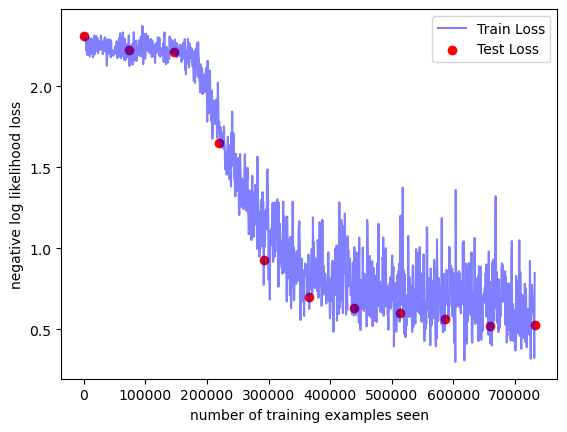

In [154]:
fig = plt.figure()
plt.plot(train_counter_layer1_pool, train_losses_layer1_pool, color='blue', alpha=.5)
plt.scatter(test_counter_layer1_pool, test_losses_layer1_pool, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [155]:
with torch.no_grad():
  output_layer1_pool = network_layer1_pool(example_data)

C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\449702964.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


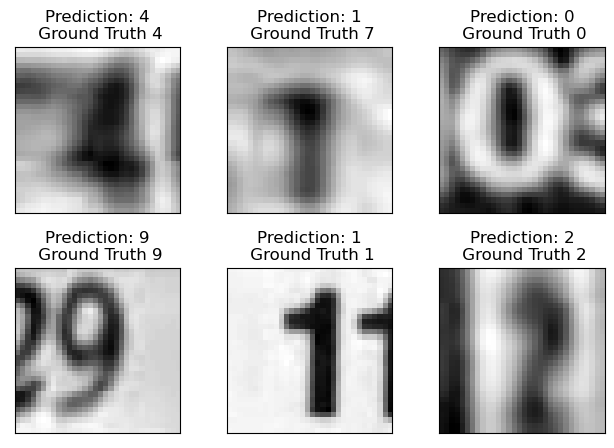

In [156]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  pred = output_layer1_pool.data.max(1, keepdim=True)[1][i].item()
  plt.title("Prediction: {}\n Ground Truth {}".format(pred, example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

### Pooling only after second layer

In [157]:
network_layer2_pool = Layer2MaxPoolNet()
zero_pad_optimizer = optim.SGD(network_layer2_pool.parameters(), lr=learning_rate,
                      momentum=momentum)

In [158]:
train_losses_layer2_pool = []
train_counter_layer2_pool = []
test_losses_layer2_pool = []
test_counter_layer2_pool = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [159]:
print(example_data.shape)
test(network_layer2_pool, test_losses_layer2_pool)
for epoch in range(1, n_epochs + 1):
  train(network_layer2_pool, zero_pad_optimizer, 
        epoch, train_losses_layer2_pool, train_counter_layer2_pool)
  test(network_layer2_pool, test_losses_layer2_pool)

torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\449702964.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2981, Accuracy: 2539/26032 (10%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.309293
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.280958
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.284808
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.276654
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.314193
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.248246
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.226577
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.324406
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.272072
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.274847
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.262838
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.197372
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.236109
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.193966
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.248274
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.307852
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.270920
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.222811
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.220106
Train Epoch: 1 [12160/7

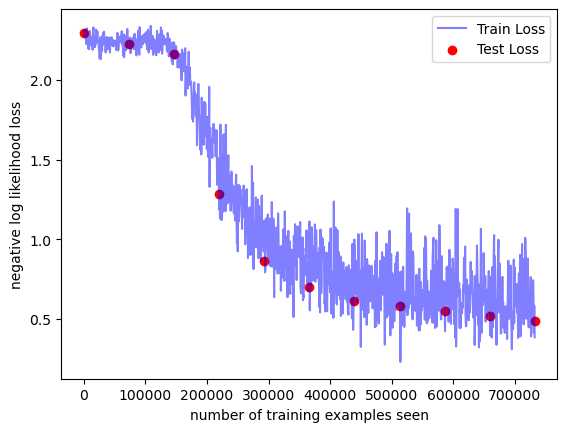

In [160]:
fig = plt.figure()
plt.plot(train_counter_layer2_pool, train_losses_layer2_pool, color='blue', alpha=.5)
plt.scatter(test_counter_layer2_pool, test_losses_layer2_pool, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [161]:
with torch.no_grad():
  output_layer2_pool = network_layer2_pool(example_data)

C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\449702964.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


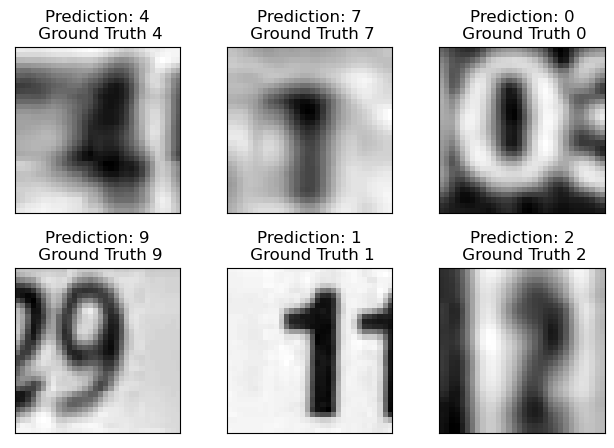

In [162]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  pred = output_layer2_pool.data.max(1, keepdim=True)[1][i].item()
  plt.title("Prediction: {}\n Ground Truth {}".format(pred, example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()